In [1]:
# increase the width of the notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<h2 style="text-align:center;"> HELLENIC OPEN UNIVERSITY - SCHOOL OF SCIENCE AND TECHNOLOGY</h2>
<h2 style="text-align:center;"> DATA SCIENCE AND MACHINE LEARNING : DAMA61 ACAD. YEAR 2024-25</h2>

<h3 style="text-align:center;"> WRITTEN ASSIGNMENT 6 - Solutions</h3>

<hr>

### Problem 1

In this assignment, you will work with a filtered version of the Fashion MNIST dataset to explore the ability of autoencoders to compress and reconstruct image data. You will build and evaluate two autoencoder variants and compare their performance based on various experimental setups. Make sure to print any output you consider important to support your observations.

1) Load the Fashion MNIST dataset from the **tensorflow.keras.datasets** module. Keep only the instances that belong to the following three classes: ‘Sandal’, ‘Sneaker’, and ‘Ankle boot’. Split the filtered dataset into a training set (5/7), a validation set (1/7), and a test set (1/7). Make sure the split uses stratified sampling to preserve class balance. Scale all subsets so pixel values are in the range [0, 1]. Print the class distribution of each subset with clear, labeled messages. <b>[5%]</b></br></br>

2) Build a stacked autoencoder with the following architecture consisting of an encoder and a decoder part of two fully-connected (Dense) layers each. Use **ReLU** activation for all hidden layers, and **sigmoid** activation for the output layer. Flatten the input before feeding it to the encoder, and reshape the output to match the original image shape (28×28). Set the latent space (codings) size to 50, and all other hidden layers to 256 units. Compile the model using: **Nadam** optimizer with learning rate 1e-4, adding **binary cross-entropy** as the loss function. Print the model summary of this autoencoder. <b>[35%]</b></br></br>

3) Now, build a second autoencoder that is identical in architecture to the one in Question 2, add $\mathcal{l}_1$ regularization to the latent space (the bottleneck layer) and use an activity regularizer with weight 1e-6. Print the model summary for this sparse autoencoder. <b>[25%]</b></br></br>

4) Train both autoencoders (from Q2 and Q3) for up to 50 epochs. Use early stopping with patience=5, and min_delta equal to 1e-2, monitoring the validation loss. Train each model with two different batch sizes: 32 and 256. This gives you 4 experiments in total (2 models × 2 batch sizes). After running your experiments, plot the training and validation loss curves for all of them. Add your comments on the differences observed between the models and batch sizes. <b>[25%]</b></br></br>

5) Write a function that compares original images with their reconstructions from an autoencoder. The function should:

- Accept a model, a set of images, and the number of images to display as input.
- Display a grid where the top row shows the original images, and the bottom row shows the reconstructed images
- Ensure the pixel values are clipped to the range [0, 1] for proper visualization

Then use this function to display the first 15 test images along with their reconstructions from the regular autoencoder trained with batch size 256, and the sparse autoencoder trained with batch size 256. <b>[10%]</b>

#### Question 1

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import random

# Set random seed for reproducibility
RANDOM_STATE = 42

# Load Fashion MNIST
(x_train_full, y_train_full), (x_test_full, y_test_full) = fashion_mnist.load_data()

# Class labels
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Filter classes
selected_classes = [5, 7, 9]
selected_class_names = [class_names[i] for i in selected_classes]

train_mask = np.isin(y_train_full, selected_classes)
x_filtered = x_train_full[train_mask]
y_filtered = y_train_full[train_mask]

# First split: Train (5/7) and temp (2/7)
X_train, X_temp, y_train, y_temp = train_test_split(
    x_filtered, y_filtered, test_size=2/7, random_state=RANDOM_STATE, stratify=y_filtered
)

# Second split: Validation (1/7) and Test (1/7)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (12857, 28, 28), y_train shape: (12857,)
X_val shape: (2571, 28, 28), y_val shape: (2571,)
X_test shape: (2572, 28, 28), y_test shape: (2572,)


In [3]:
from collections import Counter

#  Check the class distribution
train_counter = Counter(y_train)
val_counter = Counter(y_val)
test_counter = Counter(y_test)


print("Training set class distribution:", train_counter)
print("Validation set class distribution:", val_counter)
print("Test set class distribution:", test_counter)

Training set class distribution: Counter({5: 4286, 7: 4286, 9: 4285})
Validation set class distribution: Counter({5: 857, 7: 857, 9: 857})
Test set class distribution: Counter({9: 858, 7: 857, 5: 857})


In [4]:
# Normalize the data
X_train = X_train.astype("float32") / 255.0
X_val = X_val.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

print(f"Train subset range: {X_train.min()} - {X_train.max()}")
print(f"Validation subset range: {X_val.min()} - {X_val.max()}")
print(f"Test subset range: {X_test.min()} - {X_test.max()}")

Train subset range: 0.0 - 1.0
Validation subset range: 0.0 - 1.0
Test subset range: 0.0 - 1.0


#### Question 2

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Nadam
import tensorflow as tf

# Set random seed for reproducibility
tf.random.set_seed(RANDOM_STATE)


# Input shape (28x28 flattened)
input_shape = (28, 28)
flatten_dim = input_shape[0] * input_shape[1]
codings = 50
hidden_dim = 256


def model_variant1():
    
    # Define the autoencoder
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)                      

    # Encoder
    encoded = Dense(hidden_dim, activation='relu')(x)
    encoded = Dense(codings, activation='relu')(encoded)

    # Decoder
    decoded = Dense(hidden_dim, activation='relu')(encoded)
    decoded = Dense(flatten_dim, activation='sigmoid')(decoded)

    # Reshape output to image format
    outputs = Reshape(input_shape)(decoded)

    # Build model
    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer=Nadam(learning_rate=1e-4), loss='binary_crossentropy')

    return autoencoder

# Create the model
autoencoder_variant1 = model_variant1()

# Print the model summary
print("Model summary:")
autoencoder_variant1.summary()

Model summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 50)                12850     
                                                                 
 dense_2 (Dense)             (None, 256)               13056     
                                                                 
 dense_3 (Dense)             (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 28, 28)   

#### Question 3

In [6]:
from tensorflow.keras.regularizers import l1

def model_variant2():
    
    np.random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    
    # Define the autoencoder
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)                      

    # Encoder
    encoded = Dense(hidden_dim, activation='relu')(x)
    encoded = Dense(codings, activation='relu', activity_regularizer=l1(1e-6))(encoded)

    # Decoder
    decoded = Dense(hidden_dim, activation='relu')(encoded)
    decoded = Dense(flatten_dim, activation='sigmoid')(decoded)

    # Reshape output to image format
    outputs = Reshape(input_shape)(decoded)

    # Build model
    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer=Nadam(learning_rate=1e-4), loss='binary_crossentropy')

    return autoencoder


# Create the model
autoencoder_variant2 = model_variant2()

# Print the model summary
print("Model Variant 2 Summary:")
autoencoder_variant1.summary()

Model Variant 2 Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 50)                12850     
                                                                 
 dense_2 (Dense)             (None, 256)               13056     
                                                                 
 dense_3 (Dense)             (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 

#### Question 4

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

best_epoch = {}

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.01,
    verbose=1
)

# Fit the models
history_model1_bs_256 = autoencoder_variant1.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=50,
    batch_size=256,
    shuffle=True,
    callbacks=[early_stopping],
    verbose=1
)

best_epoch['model1_bs_256'] = early_stopping.best_epoch + 1

# reset the 1st model
autoencoder_variant1 = model_variant1()

history_model1_bs_32 = autoencoder_variant1.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=50,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stopping],
    verbose=1
)

best_epoch['model1_bs_32'] = early_stopping.best_epoch + 1


history_model2_bs_256 = autoencoder_variant2.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=50,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

best_epoch['model2_bs_256'] = early_stopping.best_epoch + 1

# reset the 2nd model
autoencoder_variant2 = model_variant2()

history_model2_bs_32 = autoencoder_variant2.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

best_epoch['model2_bs_32'] = early_stopping.best_epoch + 1      

Epoch 1/50
51/51 [==============================] - 1s 8ms/step - loss: 0.6487 - val_loss: 0.5358
Epoch 2/50
51/51 [==============================] - 0s 5ms/step - loss: 0.4300 - val_loss: 0.3661
Epoch 3/50
51/51 [==============================] - 0s 6ms/step - loss: 0.3392 - val_loss: 0.3206
Epoch 4/50
51/51 [==============================] - 0s 6ms/step - loss: 0.3107 - val_loss: 0.3029
Epoch 5/50
51/51 [==============================] - 0s 6ms/step - loss: 0.2968 - val_loss: 0.2924
Epoch 6/50
51/51 [==============================] - 0s 6ms/step - loss: 0.2876 - val_loss: 0.2849
Epoch 7/50
51/51 [==============================] - 0s 6ms/step - loss: 0.2805 - val_loss: 0.2784
Epoch 8/50
51/51 [==============================] - 0s 6ms/step - loss: 0.2742 - val_loss: 0.2727
Epoch 9/50
51/51 [==============================] - 0s 6ms/step - loss: 0.2691 - val_loss: 0.2684
Epoch 10/50
51/51 [==============================] - 0s 6ms/step - loss: 0.2649 - val_loss: 0.2642
Epoch 11/50
51/51 [

Epoch 1/50
402/402 [==============================] - 2s 4ms/step - loss: 0.3731 - val_loss: 0.2880
Epoch 2/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2734 - val_loss: 0.2636
Epoch 3/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2563 - val_loss: 0.2519
Epoch 4/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2469 - val_loss: 0.2442
Epoch 5/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2406 - val_loss: 0.2388
Epoch 6/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2360 - val_loss: 0.2348
Epoch 7/50
402/402 [==============================] - 1s 4ms/step - loss: 0.2325 - val_loss: 0.2317
Epoch 8/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2297 - val_loss: 0.2291
Epoch 9/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2271 - val_loss: 0.2269
Epoch 10/50
402/402 [==============================] - 1s 4ms/step - loss: 0.2250 - val_loss: 0.2249

Epoch 1/50
402/402 [==============================] - 2s 4ms/step - loss: 0.3713 - val_loss: 0.2858
Epoch 2/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2708 - val_loss: 0.2614
Epoch 3/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2545 - val_loss: 0.2504
Epoch 4/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2460 - val_loss: 0.2433
Epoch 5/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2397 - val_loss: 0.2377
Epoch 6/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2352 - val_loss: 0.2341
Epoch 7/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2319 - val_loss: 0.2312
Epoch 8/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2292 - val_loss: 0.2288
Epoch 9/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2270 - val_loss: 0.2270
Epoch 10/50
402/402 [==============================] - 2s 4ms/step - loss: 0.2250 - val_loss: 0.2250

In [8]:
print("Best epoch per experiment: ", best_epoch)

Best epoch per experiment:  {'model1_bs_256': 14, 'model1_bs_32': 9, 'model2_bs_256': 16, 'model2_bs_32': 9}


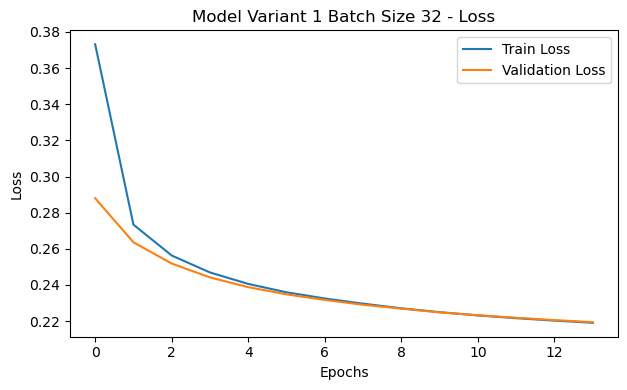

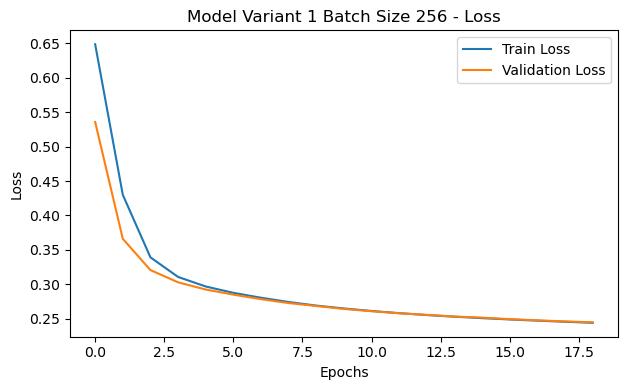

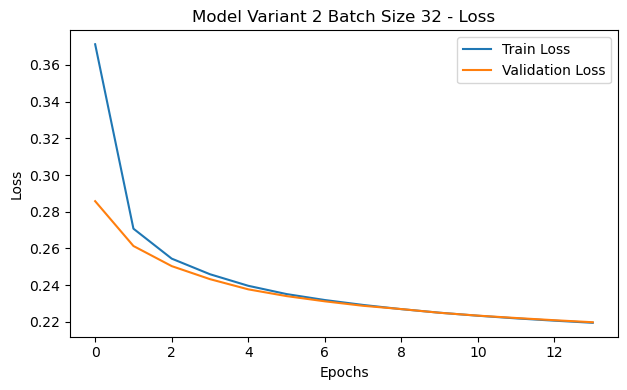

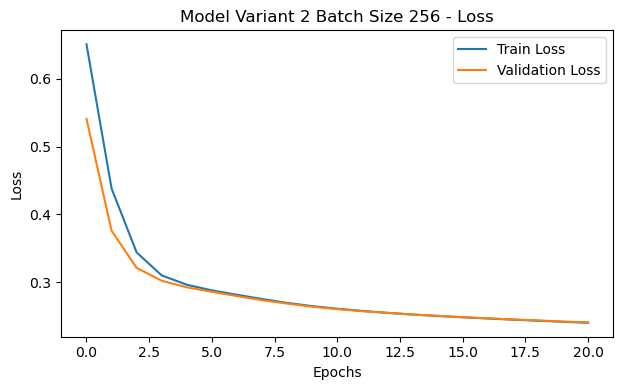

In [9]:
# Plotting the training history
import matplotlib.pyplot as plt

def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# Plot training history for both models
plot_training_history(history_model1_bs_32,  "Model Variant 1 Batch Size 32")
plot_training_history(history_model1_bs_256, "Model Variant 1 Batch Size 256")
plot_training_history(history_model2_bs_32,  "Model Variant 2 Batch Size 32")
plot_training_history(history_model2_bs_256, "Model Variant 2 Batch Size 256")

#### Question 5

In [10]:
# That function is the same with the notebook of the course
def plot_reconstructions(model, images, n_images=5):

    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    plt.figure(figsize=(n_images * 1.5, 3))
    
    for image_index in range(n_images):
        
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")

        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")


1/1 [==============================] - 0s 38ms/step


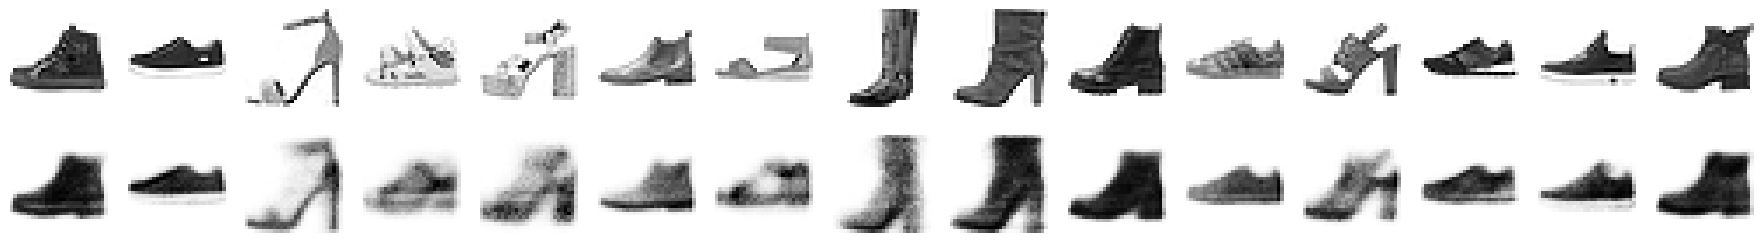

In [11]:
plot_reconstructions(autoencoder_variant1, X_test, n_images=15)
plt.show()

1/1 [==============================] - 0s 25ms/step


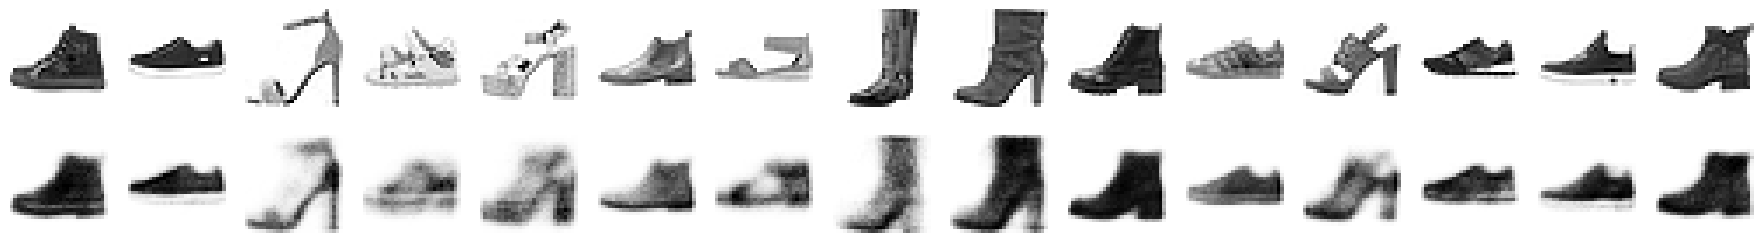

In [12]:
plot_reconstructions(autoencoder_variant2, X_test, n_images=15)
plt.show()

### Problem 2

In this assignment, you will implement and train a Generative Adversarial Network (GAN) from scratch using the Fashion-MNIST dataset. Your GAN will learn to generate synthetic fashion item images that resemble real samples from selected categories. <i>Hint: Use tensorflow ~2.14 and follow the code of the book.</i>

1) Load the Fashion-MNIST dataset through tensorflow.keras.datasets, keep the data on the training set, select and retain only the T-shirt/top, Trousers, and Pullover classes, and scale the pixel values to the range [-1, 1]. <b>[5%]</b></br></br>

2) Create a generator that takes input random noise vectors of size 30. It has two hidden layers, each with 100 and 150 units, with an activation function ReLU and a He normal kernel initializer. It outputs a fully connected layer of a 784-dimensional vector with activation tanh, which is reshaped to a 28 by 28 pixels image. <b>[20%]</b></br></br>

3) Create a Discriminator that reads a 28 by 28 pixel image and classifies it as “real” or “fake”. The Discriminator consists of two hidden layers, each with 150 and 100 units, with an activation function ReLU and a He normal kernel initializer. A sigmoid function activates the output layer. <b>[20%]</b></br></br>

4) Connect the generator and discriminator to set up a GAN pipeline. Use the Binary Cross Entropy as the loss function and the RMSProp optimizer for both the discriminator and the GAN models. Create batches of 32 images by slicing the training set. Train the GAN for 10 epochs, alternating between updating the Discriminator and Generator models on each batch. After each epoch of training ends, visualize 32 generated images. <b>[35%]</b></br></br>

5) After training, feed the Generator with 32 random noise vectors and visualize the 32 generated images. Are you satisfied with the results? <b>[10%]</b></br></br>

6) What is the accuracy of the discriminator in predicting that the generated images of the previous question are fake? <b>[10%]</b>

In [13]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

#### Question 1

In [14]:
CLASSES = [0, 1, 2]  # T-shirt/top, Trouser, Pullover

(X_train, y_train), _ = tf.keras.datasets.fashion_mnist.load_data()

mask = np.isin(y_train, CLASSES)
X_train = X_train[mask].astype("float32") / 127.5 - 1  # Scale to [-1, 1]
y_train = y_train[mask]

#### Question 2

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape

tf.random.set_seed(42)

codings_size = 30

generator = Sequential([
    Dense(100, activation = "relu", kernel_initializer = "he_normal"),
    Dense(150, activation = "relu", kernel_initializer = "he_normal"),
    Dense(28 * 28, activation = "tanh"),
    Reshape([28, 28])
])

#### Question 3

In [16]:
discriminator = Sequential([
    Flatten(),
    Dense(150, activation = "relu", kernel_initializer = "he_normal"),
    Dense(100, activation = "relu", kernel_initializer = "he_normal"),
    Dense(1, activation = "sigmoid")
])

#### Question 4

In [17]:
# Combine the generator and the discriminator model under the GAN
gan = Sequential([generator, discriminator])

# Compile the models
discriminator.compile(loss = "binary_crossentropy", optimizer = "rmsprop")
discriminator.trainable = False  # Fix the discriminators weight when training the generator

gan.compile(loss = "binary_crossentropy", optimizer = "rmsprop")

In [18]:
# visualize a given set of images
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
    plt.show()

In [19]:
# Slice the dataset into batches
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [20]:
# built the training loop of both the GAN and the discriminator

def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    
    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        
        print(f"Epoch {epoch + 1}/{n_epochs}")

        # for each batch
        for X_batch in dataset:
            
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)

            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(x = X_fake_and_real, y = y1)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

        # visualize the generated images during training
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

Epoch 1/10


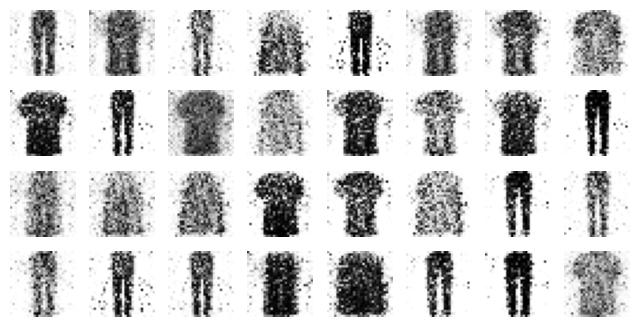

Epoch 2/10


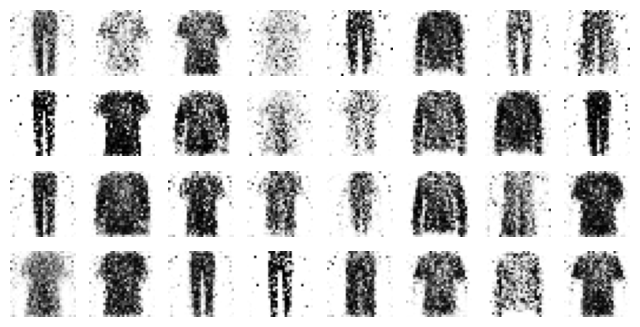

Epoch 3/10


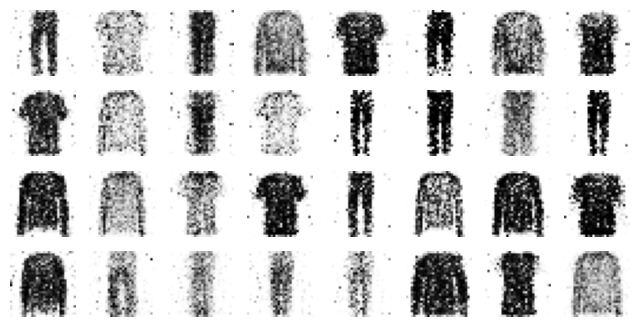

Epoch 4/10


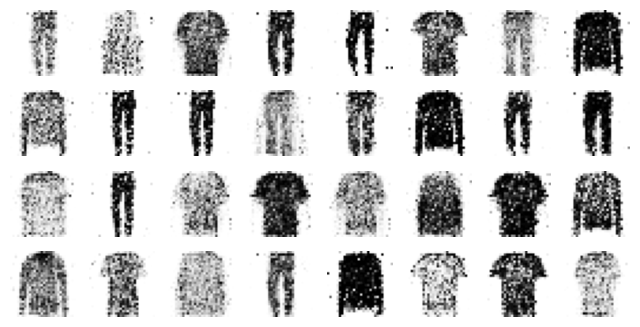

Epoch 5/10


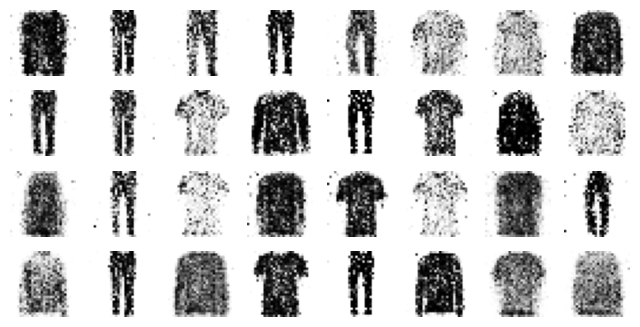

Epoch 6/10


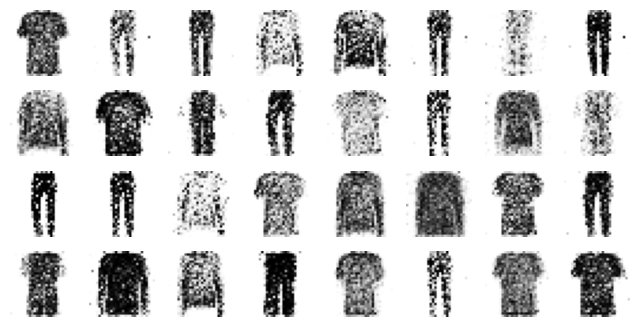

Epoch 7/10


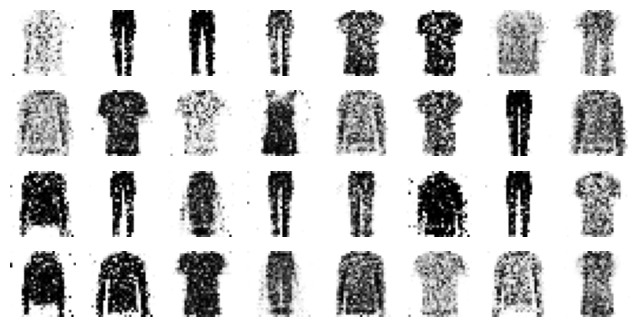

Epoch 8/10


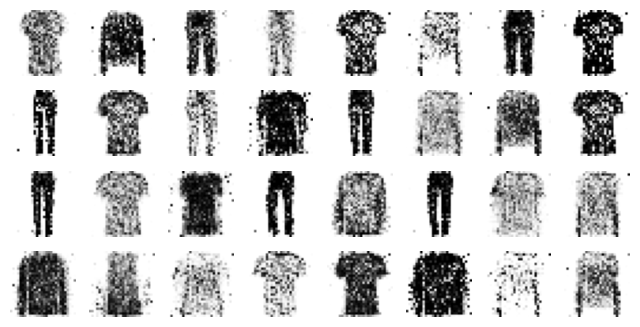

Epoch 9/10


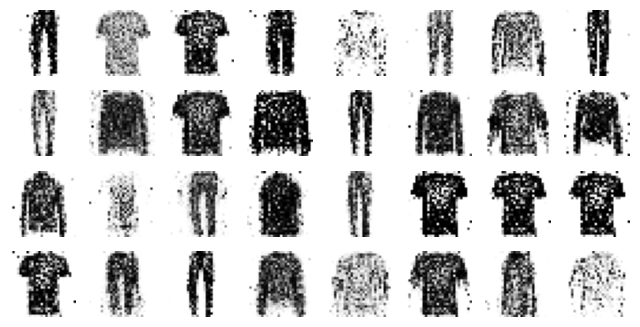

Epoch 10/10


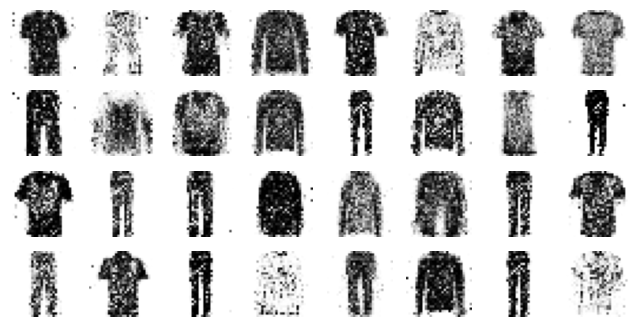

In [21]:
# train the models for 10 epochs
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

#### Question 5

In [22]:
tf.random.set_seed(42)  # ensures reproducibility on CPU

codings = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(codings)

1/1 [==============================] - 0s 18ms/step


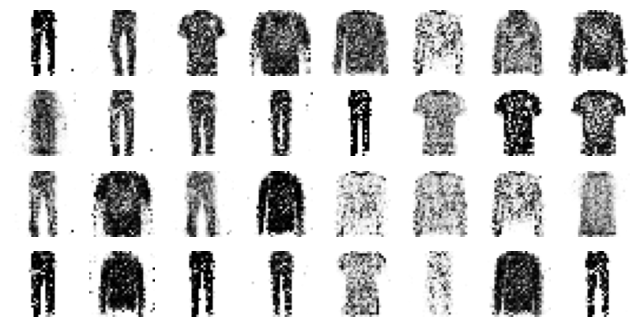

In [23]:
plot_multiple_images(generated_images, 8)

#### Question 6

In [24]:
predictions = discriminator.predict(generated_images)
fake = (predictions < 0.5).astype(int)  # less than 0.5 probability beeing a real image

1/1 [==============================] - 0s 18ms/step


In [25]:
print(f"Correctly classified as fake images: {fake.sum()/batch_size:%}")

Correctly classified as fake images: 46.875000%


The discriminator predicts about half (47%) of the generated images are fake.